In [1]:
import os
from itertools import product
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm.autonotebook import tqdm

import bandit.environment as env
from bandit.bandit import Bandit, PerArmBandit
from bandit.policy import EGreedy, Softmax
from bandit.utils import snapshot

sns.set_theme()

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_38255/1555042788.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_38255/1555042788.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import re


def to_snake_case(s):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", s).lower()

## Setup Variables

In [3]:
N = 1_000
n_arms = len(env.actions)

In [4]:
file_name = "contextual_bandit.csv"
if not os.path.exists(file_name):
    df = pd.DataFrame(index=range(N))
    df.to_csv(file_name)
else:
    df = pd.read_csv(file_name)
df.head()

""
0
1
2
3
4


In [5]:
def run_simulation(bandit, policy, n=N, dynamic=False):
    total_reward = 0
    avg_rewards = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(N)):
        state = env.observe(rng)

        # 1. Predict the action.
        rewards = bandit.pull(state)

        action = policy(rewards)

        # 2. Act and get the reward.
        if dynamic and i > N // 2:
            get_cost = env.get_cost_new
        else:
            get_cost = env.get_cost
        reward = get_cost(state, env.actions[action])

        # 3. Update the model.
        bandit.update(state, action, reward)

        # 4. Save the reward.
        total_reward += max(0, reward)
        avg_rewards.append(total_reward / (i + 1))
    return avg_rewards, total_reward

## Setting up Contextual MAB

In [6]:
models = [
    LogisticRegression(random_state=42),
    DecisionTreeRegressor(random_state=42),
    MLPRegressor(random_state=42),
]
policies = [
    EGreedy(epsilon=0.0),
    Softmax(tau=0.2),
]

for model, policy in product(models, policies):
    model_name = f"{model.__class__.__name__}MAB_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(Bandit(model, n_arms), policy)
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

Running logistic_regression_m_a_b__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.78it/s]


Running logistic_regression_m_a_b__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 676.56it/s]


Running decision_tree_regressor_m_a_b__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 587.38it/s]


Running decision_tree_regressor_m_a_b__softmax_tau_0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1279.19it/s]


Running m_l_p_regressor_m_a_b__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 387.80it/s]


Running m_l_p_regressor_m_a_b__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.10it/s]


## Setting up PerArm Contextual Bandit

In [7]:
models = [
    [LogisticRegression(random_state=42) for _ in range(n_arms)],
    [DecisionTreeRegressor(random_state=42) for _ in range(n_arms)],
    [MLPRegressor(random_state=42) for _ in range(n_arms)],
]
policies = [
    EGreedy(epsilon=0.0),
    Softmax(tau=0.2),
]

for models, policy in product(models, policies):
    model = models[0]
    model_name = f"{model.__class__.__name__}PerArm_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(PerArmBandit(models), policy)
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

Running logistic_regression_per_arm__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.66it/s]


Running logistic_regression_per_arm__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.88it/s]


Running decision_tree_regressor_per_arm__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.19it/s]


Running decision_tree_regressor_per_arm__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.19it/s]


Running m_l_p_regressor_per_arm__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.05it/s]


Running m_l_p_regressor_per_arm__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 242.70it/s]


## Setting up Dynamic MAB Contextual Bandit

In [8]:
models = [
    LogisticRegression(random_state=42),
    DecisionTreeRegressor(random_state=42),
    MLPRegressor(random_state=42),
]
policies = [
    EGreedy(epsilon=0.0),
    Softmax(tau=0.2),
]

for model, policy in product(models, policies):
    model_name = f"{model.__class__.__name__}MAB_Dynamic_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(
            Bandit(model, n_arms), policy, dynamic=True
        )
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

Running logistic_regression_m_a_b__dynamic__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 732.57it/s]


Running logistic_regression_m_a_b__dynamic__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 639.99it/s]


Running decision_tree_regressor_m_a_b__dynamic__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 949.90it/s]


Running decision_tree_regressor_m_a_b__dynamic__softmax_tau_0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1005.30it/s]


Running m_l_p_regressor_m_a_b__dynamic__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.25it/s]


Running m_l_p_regressor_m_a_b__dynamic__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.12it/s]


## Setting up Dynamic PerArm Contextual Bandit

In [9]:
models = [
    [LogisticRegression(random_state=42) for _ in range(n_arms)],
    [DecisionTreeRegressor(random_state=42) for _ in range(n_arms)],
    [MLPRegressor(random_state=42) for _ in range(n_arms)],
]
policies = [
    EGreedy(epsilon=0.0),
    Softmax(tau=0.2),
]

for models, policy in product(models, policies):
    model = models[0]
    model_name = f"{model.__class__.__name__}PerArm_Dynamic_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(
            PerArmBandit(models), policy, dynamic=True
        )
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

Running logistic_regression_per_arm__dynamic__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.52it/s]


Running logistic_regression_per_arm__dynamic__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.50it/s]


Running decision_tree_regressor_per_arm__dynamic__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.43it/s]


Running decision_tree_regressor_per_arm__dynamic__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.70it/s]


Running m_l_p_regressor_per_arm__dynamic__e_greedy_eps_0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.75it/s]


Running m_l_p_regressor_per_arm__dynamic__softmax_tau_0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.84it/s]


In [10]:
# Override
# You will get unnamed columns if saved with index=True
# df[[col for col in df.columns if 'Unnamed' not in col]]
# df.to_csv(file_name, index=False)

In [11]:
def plot(*patterns):
    cols = df.columns
    for pat in patterns:
        cols = list(filter(lambda col: pat in col, cols))

    style = []
    for col in cols:
        if "e_greedy" in col:
            style.append("-")
        elif "softmax" in col:
            style.append("--")
        else:
            style.append("-")
    df[cols].plot(
        figsize=(12, 8),
        style=style,
        xlabel="Trials",
        ylabel="Avg. Rewards",
        title="Contextual Bandit",
    )

## Plots

### All

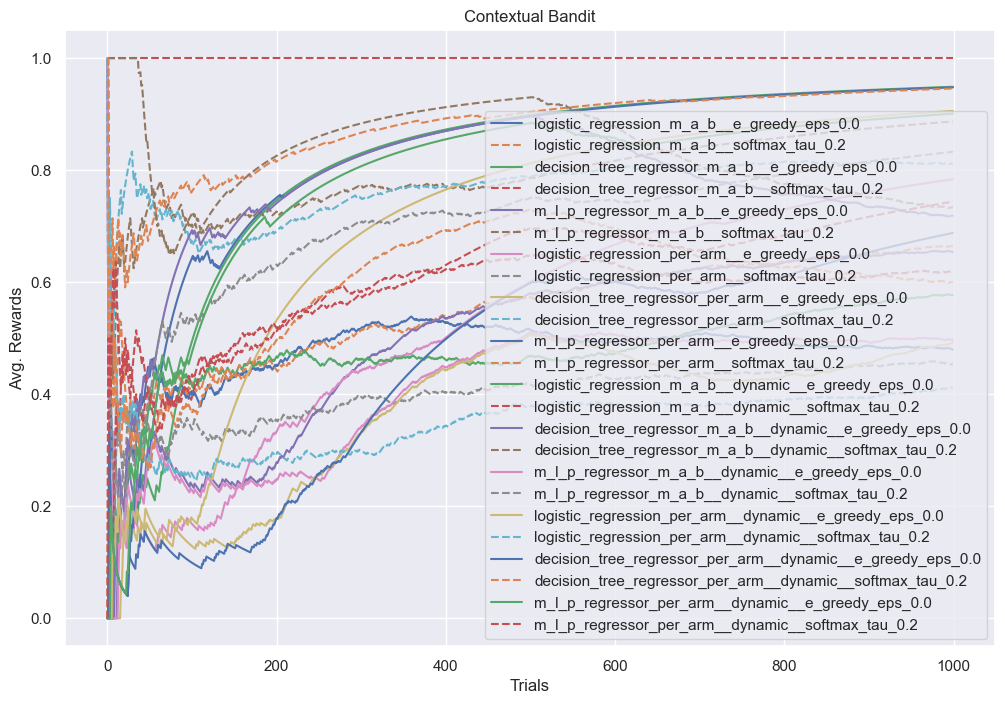

In [12]:
plot()

### Softmax PerArm

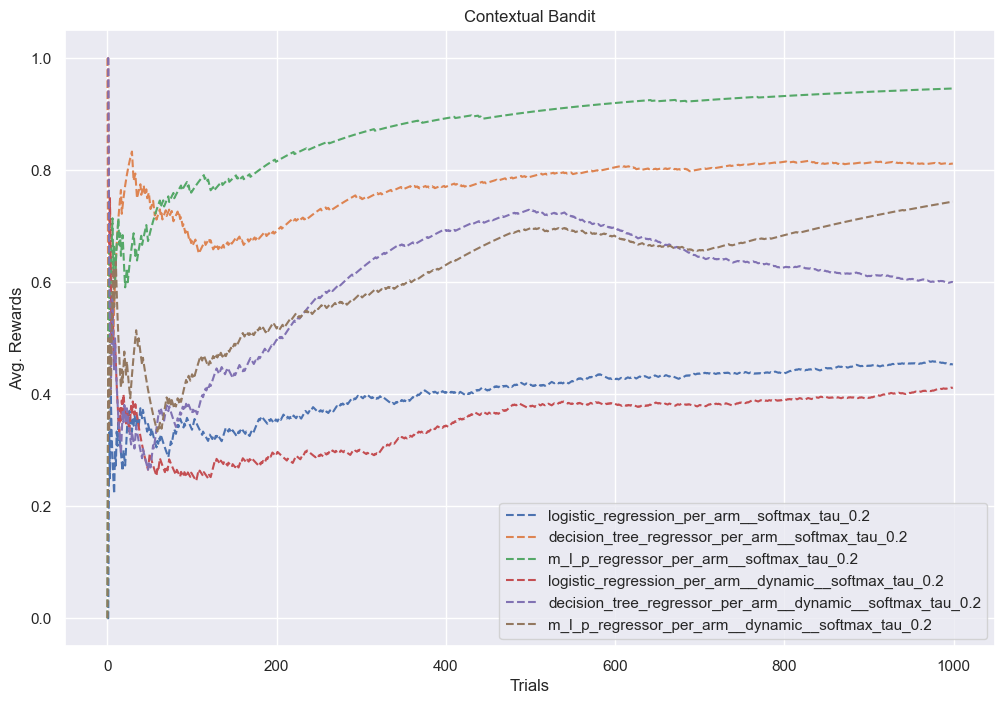

In [13]:
plot("per_arm", "softmax")

### Softmax MAB

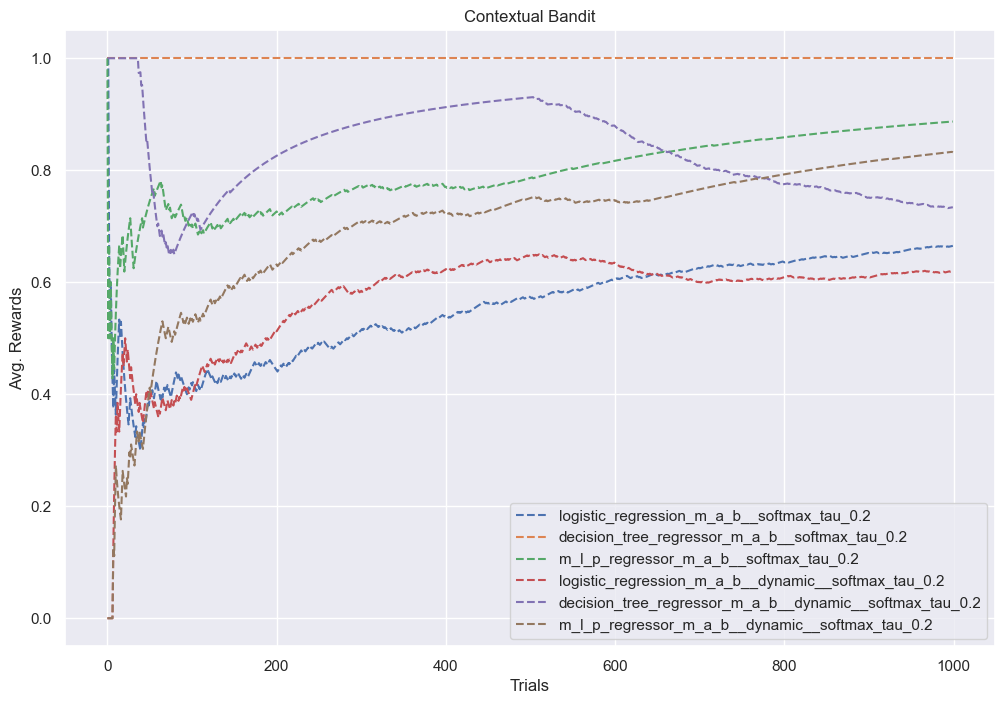

In [14]:
plot("m_a_b", "softmax")

## Softmax Dynamic MAB

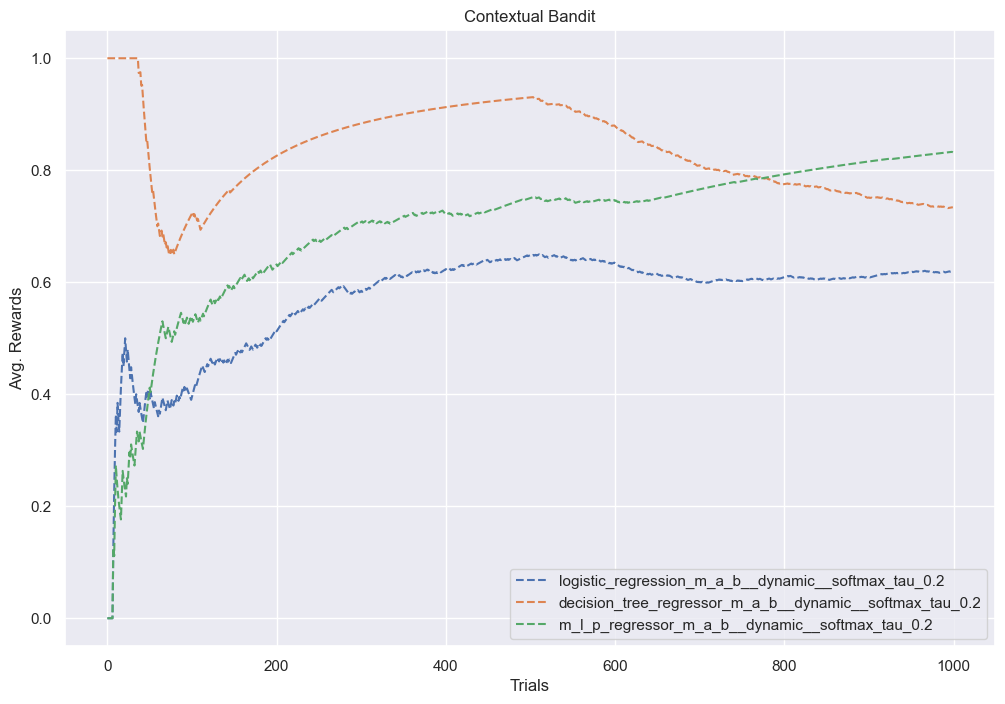

In [15]:
plot("m_a_b", "softmax", "dynamic")

## Softmax Dynamic Per Arm

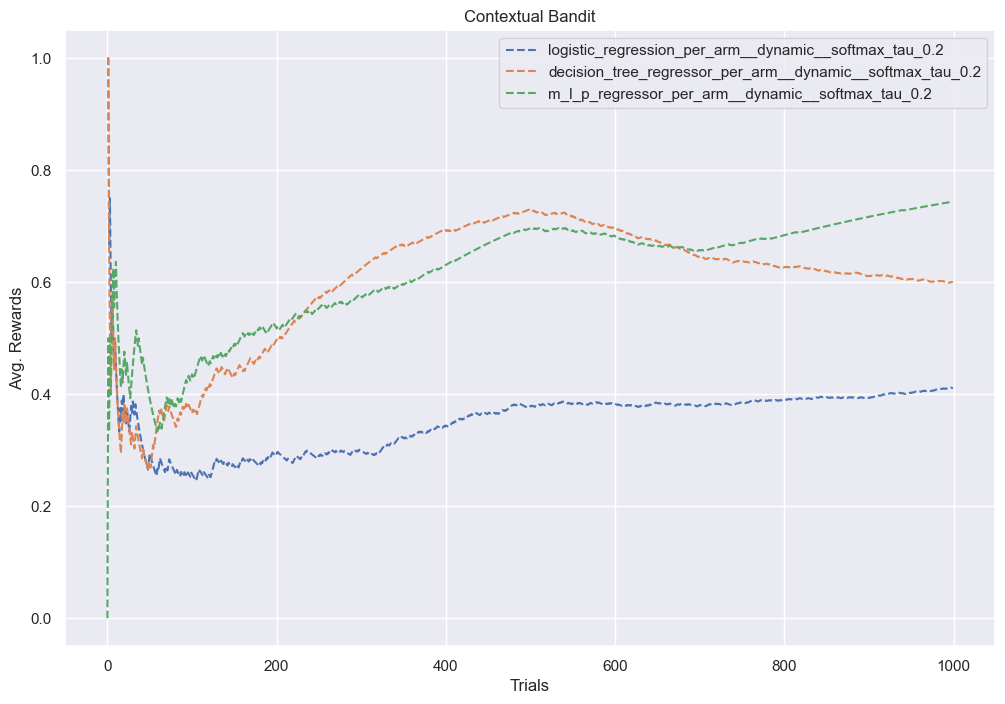

In [16]:
plot("per_arm", "softmax", "dynamic")

## E-Greedy

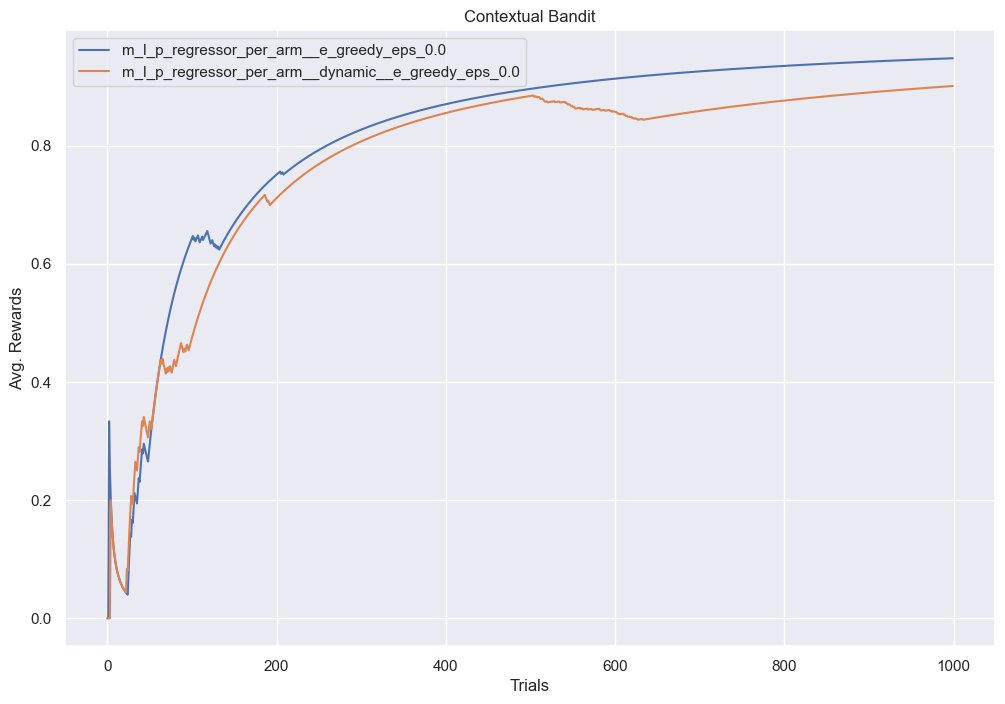

In [17]:
plot("per_arm", "e_greedy", "m_l_p")

## Speed/Accuracy Tradeoffs

We can pick the best performing bandit by plotting a scatter chart of accuracy against elapsed time. In short, we want the bandit to be in the top left quadrant (short prediction time, but highest accuracy).

In [18]:
import json

with open("contextual_bandit.json", "r") as f:
    data = json.load(f)

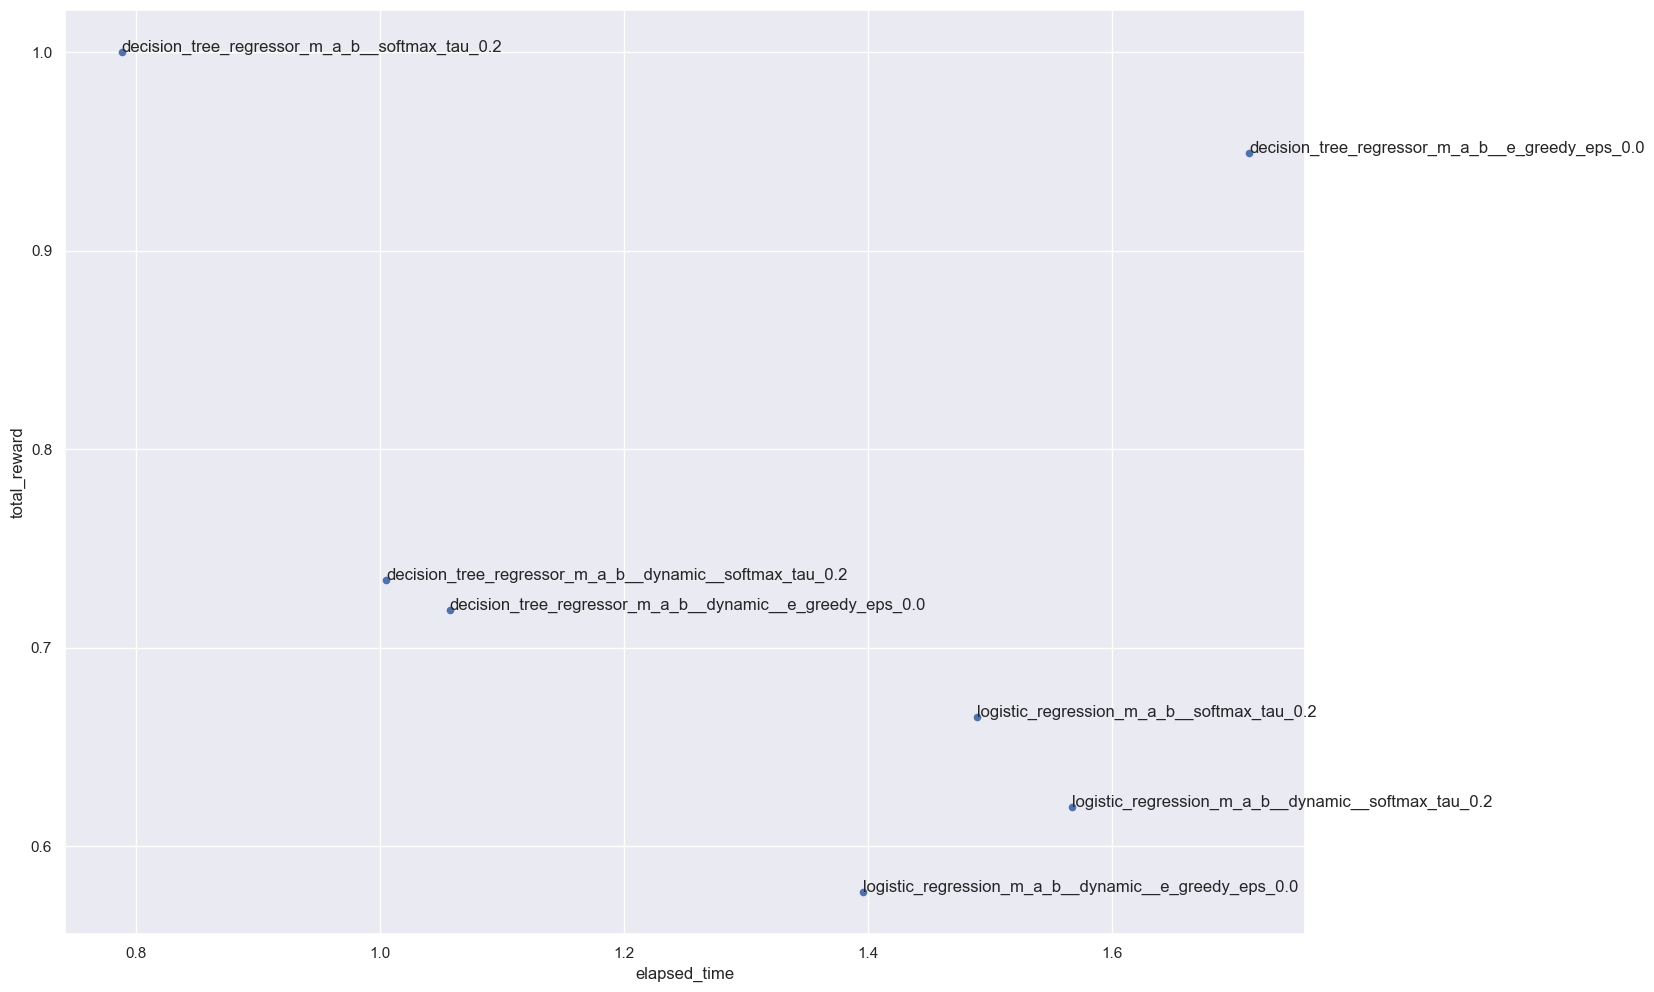

In [19]:
%matplotlib inline
import pandas as pd

df = pd.DataFrame(data).T
x, y = "elapsed_time", "total_reward"
df[y] /= N
# Less than 2.5 seconds, but more than half the rewards.
df = df[(df[x] < 2.5) & (df[y] > 0.5)]
ax = df.plot.scatter(x=x, y=y, figsize=(16, 12))

# Add text to each point
for _, row in df.iterrows():
    ax.text(row[x], row[y], row.name, fontsize=12)

In [20]:
x, y

('elapsed_time', 'total_reward')